# Actity Recognition From RGB-D Images

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import PIL.Image
import numpy as np
from fastai.vision import *
import xml.etree.cElementTree as ET
import matplotlib.pyplot as plt
from fastai.metrics import error_rate

## Dataset Variables

In [19]:
dataset_path = "/src/users/Kevin/UTKinect"
folders = ["depth","rgb"]
label_fname = "actionLabel.txt"

In [20]:
data_dict = {"depth":[],"rgb":[],"labels":[],"rgbd":[]}
# For reference: 
DATA_SIZE = 5865

## Download

Ignore this part if the dataset is already downloaded.

In [21]:
depth_url = "https://cvrc.ece.utexas.edu/KinectDatasets/depth.zip"
rgb_url = "https://cvrc.ece.utexas.edu/KinectDatasets/RGB.zip"
label_url = "https://cvrc.ece.utexas.edu/KinectDatasets/actionLabel.txt"

In [ ]:
RGBD_Activity_Detection

In [ ]:
download_url(rgb_url,dataset_path+"/rgb.zip")

In [ ]:
download_url(label_url,"%s/%s"%(dataset_path,label_fname))

Before contininuing, go to folder where data was downloaded and unzip data.

## Load Helper Functions

In [22]:
def string_Arr_to_float(str_arr):
    """
    func: convert all string numbers in list to float
    param:  list of string numbers
    out:  list of float numbers
    """
    for x in range(len(str_arr)):
        str_arr[x] = float(str_arr[x])
    return str_arr

In [23]:
def depth_xml_to_arr(imgFilePath, depthFilePath,beginFrm, endFrm, label):
    """
    func: load depth image data from given range of frames, and append label
    param: depthFilePath - path to file where frames are found
           beginFrm - first frame of activty 
           endFrm - last frame of activty
           label - label of activity
    out: list of touples contatining depth data of each frame between beginFrm and endFrm and label
    """  
    xmlFiles = [f for f in os.listdir(depthFilePath) if f.endswith('.xml')]
    xmlFiles.sort(key=lambda item: (len(item), item))
    
    depthSequence = [[],[]]
    
    beginFrmFile = "depthImg%i.xml" %beginFrm
    endFrmFile = "depthImg%i.xml" %endFrm
    
    beginIdx = xmlFiles.index(beginFrmFile)
    endIdx = xmlFiles.index(endFrmFile)
    useXmlFiles = xmlFiles[beginIdx:endIdx+1]
    
    for xmlFile in useXmlFiles:
        imgFile = xmlFile.replace("depthImg","colorImg").replace(".xml",".jpg")
        img = PIL.Image.open(os.path.join(imgFilePath, imgFile))
        
        tree = ET.parse(os.path.join(depthFilePath, xmlFile))
        filename, _ = os.path.splitext(xmlFile)
        elem = tree.find('%s/data' % filename)
        strData = elem.text
        str_Arr = strData.split()
        floatData = string_Arr_to_float(str_Arr)
        arr = np.array(floatData)
        depthData = np.array(floatData).reshape(240, 320)
        
        img = img.resize((320,240))
        rgb = np.array(img)
        
        data_dict["rgb"].append(rgb)
        data_dict["depth"].append(depthData)
        data_dict["labels"].append(label)
        #data_dict["rgbd"].append(np.concatenate((rgb, depthData), axis = 2))

In [24]:
def load_depth_imgs(img_path,depth_path,label_fname):
    """
    func: load depth image data from xml file
    param: depth_path - path to folder with depth data
           label_fname - name of the label txt file
    out: list of touples with depth img and activity label
    """    
    configFile = os.path.join(dataset_path, label_fname)
    with open(configFile, "r") as f:
        lines = f.read().splitlines()

    for i in range(0,220,11):
        currLines = lines[i:i+11]
        depthFileDir = currLines[0]

        print("loading %s" %depthFileDir)
        for line in currLines[1:]:
                splitIdx = line.index(":")
                label = line[:splitIdx]
                nums = line[splitIdx+1:].split()
                beginFrm = int(nums[0])
                endFrm = int(nums[1])
                
                depthFilePath = os.path.join(depth_path,depthFileDir)
                imgFilePath = os.path.join(img_path,depthFileDir)
                
                depth_xml_to_arr(imgFilePath, depthFilePath,beginFrm, endFrm, label)
    
    print("loading complete!")

## Load Data  

In [25]:
depth_path = dataset_path + "/depth"
img_path = dataset_path + "/RGB"
load_depth_imgs(img_path,depth_path,label_fname)

loading s01_e01
loading s01_e02
loading s02_e01
loading s02_e02
loading s03_e01
loading s03_e02
loading s04_e01
loading s04_e02
loading s05_e01
loading s05_e02
loading s06_e01
loading s06_e02
loading s07_e01
loading s07_e02
loading s08_e01
loading s08_e02
loading s09_e01
loading s09_e02
loading s10_e01
loading s10_e02
loading complete!


In [30]:
len(data_dict["rgb"])

5865

In [31]:
depthData = torch.from_numpy(np.array(data_dict['depth'])).permute(0,1,2).type(torch.FloatTensor)
depthData = depthData[:,None,:,:]

In [32]:
imageData = torch.from_numpy(np.array(data_dict['rgb'])).permute(0,3,1,2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5775cfb040>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5775fb2040>)

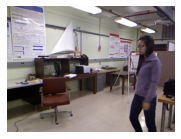

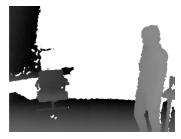

In [33]:
show_image(imageData[0]), show_image(depthData[0])

## Setting Up Learner

In [34]:
class ImageListRGBD(ImageList):
    def open(self, i):
        rgb = imageData[i].type(torch.FloatTensor)
        rgbd = torch.cat((rgb,depthData[i]),0)
        return Image(rgbd)

In [35]:
items = list(range(len(imageData)))
images = ImageListRGBD(items)

In [36]:
# Split data into train and valid
num_train = int(DATA_SIZE * 0.8); num_train

4692

In [37]:
images = images.split_by_rand_pct()
func = lambda i:data_dict["labels"][i]
images = images.label_from_func(func)
model = ln.models.YoloFusion()

NameError: name 'ln' is not defined

In [38]:
tfms = None #get_transforms(max_rotate=25)# or tfms=None if none are needed
size=224 # size=(224,224) or (400,224)
data = images.transform(tfms,size=224).databunch().normalize()

In [39]:
data.classes

['carry',
 'clapHands',
 'pickUp',
 'pull',
 'push',
 'sitDown',
 'standUp',
 'throw',
 'walk',
 'waveHands']

In [40]:
data.batch_size = 64

## Learner

Modified resnet model to accept 4 channel image

In [41]:
input_channel = 4
resnet = models.resnet34 ()
resnet.conv1 = torch.nn.Conv2d (input_channel, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
resnet.avgpool = nn.AdaptiveAvgPool2d ((1, 1))
resnet.fc = torch.nn.Linear(512, len(data.classes), bias=True)

In [42]:
learn = cnn_learner (data, lambda x: resnet, metrics = (error_rate,accuracy))

In [43]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py", line 127, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/collate.py", line 53, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "/usr/local/lib/python3.8/dist-packages/torch/storage.py", line 132, in _new_shared
    return cls._new_using_fd(size)
RuntimeError: unable to write to file </torch_2969_1187189337>


In [52]:
learn.fit_one_cycle(5, slice(1e-03, 1e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.504073,1.624809,0.543905,0.456095,00:12
1,1.854725,1.517203,0.502984,0.497016,00:12
2,1.394849,1.203029,0.412617,0.587383,00:12
3,0.964506,1.080116,0.370844,0.629156,00:12
4,0.669389,1.037839,0.355499,0.644501,00:12


In [53]:
learn.fit_one_cycle(8, slice(1e-03, 1e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.567213,1.049004,0.353794,0.646206,00:12
1,0.807354,1.558594,0.465473,0.534527,00:12
2,1.002545,1.131112,0.364024,0.635976,00:12
3,0.872286,1.044047,0.357204,0.642796,00:12
4,0.639118,0.946468,0.317136,0.682864,00:12
5,0.467277,0.944613,0.317988,0.682012,00:12
6,0.339121,0.896929,0.291560,0.708440,00:12
7,0.277301,0.895498,0.296675,0.703325,00:12


In [54]:
learn.save('stage-1')

## Results

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

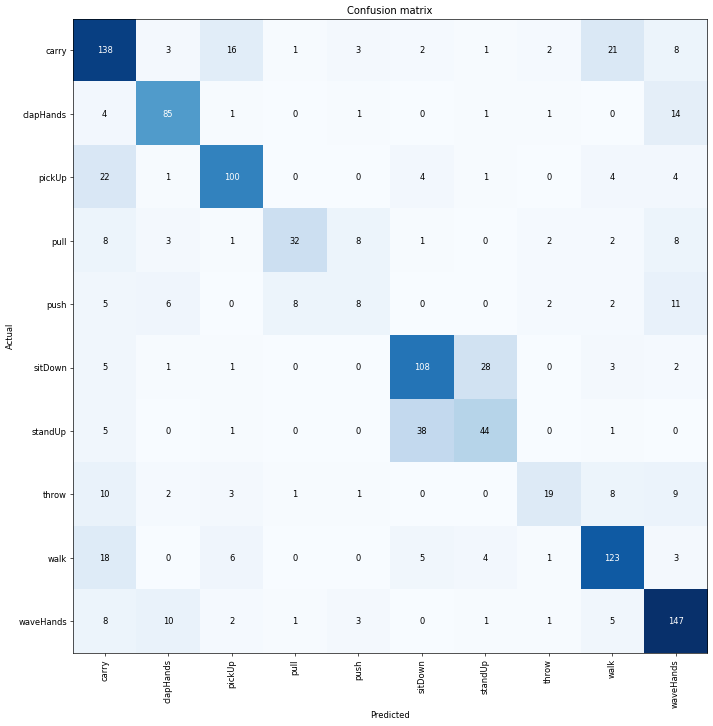

In [37]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [38]:
interp.most_confused(min_val=2)

[('standUp', 'sitDown', 38),
 ('sitDown', 'standUp', 28),
 ('pickUp', 'carry', 22),
 ('carry', 'walk', 21),
 ('walk', 'carry', 18),
 ('carry', 'pickUp', 16),
 ('clapHands', 'waveHands', 14),
 ('push', 'waveHands', 11),
 ('throw', 'carry', 10),
 ('waveHands', 'clapHands', 10),
 ('throw', 'waveHands', 9),
 ('carry', 'waveHands', 8),
 ('pull', 'carry', 8),
 ('pull', 'push', 8),
 ('pull', 'waveHands', 8),
 ('push', 'pull', 8),
 ('throw', 'walk', 8),
 ('waveHands', 'carry', 8),
 ('push', 'clapHands', 6),
 ('walk', 'pickUp', 6),
 ('push', 'carry', 5),
 ('sitDown', 'carry', 5),
 ('standUp', 'carry', 5),
 ('walk', 'sitDown', 5),
 ('waveHands', 'walk', 5),
 ('clapHands', 'carry', 4),
 ('pickUp', 'sitDown', 4),
 ('pickUp', 'walk', 4),
 ('pickUp', 'waveHands', 4),
 ('walk', 'standUp', 4),
 ('carry', 'clapHands', 3),
 ('carry', 'push', 3),
 ('pull', 'clapHands', 3),
 ('sitDown', 'walk', 3),
 ('throw', 'pickUp', 3),
 ('walk', 'waveHands', 3),
 ('waveHands', 'push', 3),
 ('carry', 'sitDown', 2),
 ('

## Back To Learner

In [40]:
input_channel = 4
resnet = models.resnet50 ()
resnet.conv1 = torch.nn.Conv2d (input_channel, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
resnet.avgpool = nn.AdaptiveAvgPool2d ((1, 1))
resnet.fc = torch.nn.Linear(512, len(data.classes), bias=True)

In [41]:
learn = cnn_learner (data, lambda x: resnet, metrics = (error_rate,accuracy))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


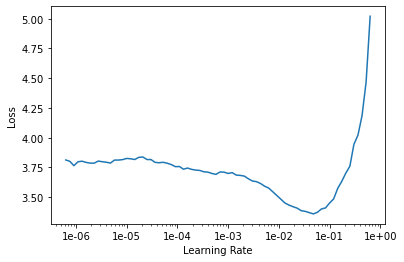

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5, slice(1e-03, 1e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.610508,1.877062,0.635124,0.364876,00:22
1,2.140257,1.881291,0.605286,0.394714,00:21
2,1.838074,1.594626,0.544757,0.455243,00:21
3,1.437526,1.444573,0.513214,0.486786,00:21
4,1.127459,1.402607,0.485934,0.514067,00:21


In [44]:
learn.fit_one_cycle(8, slice(1e-03, 1e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.995311,1.429180,0.479113,0.520887,00:21
1,1.259511,1.904596,0.597613,0.402387,00:21
2,1.524567,1.572845,0.544757,0.455243,00:21
3,1.441624,1.494122,0.519182,0.480818,00:22
4,1.242319,1.378185,0.476556,0.523444,00:22
5,0.993711,1.332528,0.457801,0.542199,00:22
6,0.810476,1.342916,0.456095,0.543905,00:21
7,0.702342,1.321724,0.456095,0.543905,00:21


In [45]:
learn.save('stage-1-50')

ResNet50 gave worse results, so we go back to ResNet34

In [62]:
input_channel = 4
resnet = models.resnet34 ()
resnet.conv1 = torch.nn.Conv2d (input_channel, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
resnet.avgpool = nn.AdaptiveAvgPool2d ((1, 1))
resnet.fc = torch.nn.Linear(512, len(data.classes), bias=True)

learn = cnn_learner (data, lambda x: resnet, metrics = (error_rate,accuracy))

learn.load('stage-1');

In [63]:
learn.fit_one_cycle(4, slice(1e-03, 1e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.298796,1.037462,0.332481,0.667519,00:12
1,0.648085,1.086041,0.345269,0.654731,00:12
2,0.598047,0.966313,0.318841,0.681159,00:12
3,0.420282,0.901635,0.315431,0.684569,00:12


In [64]:
learn.fit_one_cycle(4, slice(1e-03, 1e-02))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.357615,0.997229,0.307758,0.692242,00:12
1,0.454116,0.984163,0.299233,0.700767,00:12
2,0.409925,0.939408,0.289855,0.710145,00:12
3,0.303436,0.900746,0.288150,0.711850,00:12


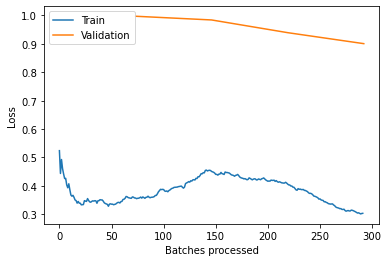

In [66]:
learn.save('stage-2')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.277077,0.953151,0.291560,0.708440,00:12
1,0.405344,1.074353,0.310315,0.689685,00:12
2,0.362536,0.917702,0.277920,0.722080,00:12
3,0.256631,0.908159,0.275362,0.724638,00:12


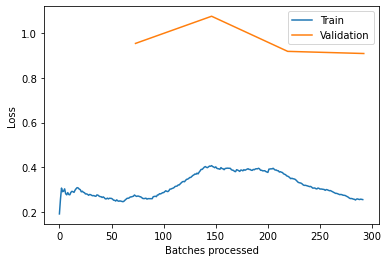

In [67]:
learn.fit_one_cycle(4, slice(1e-03, 1e-02))
learn.save('stage-3')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.232439,0.929633,0.273657,0.726343,00:12
1,0.368707,0.996117,0.274510,0.725490,00:12
2,0.347471,0.877156,0.250639,0.749361,00:12
3,0.248658,0.884179,0.248934,0.751066,00:12


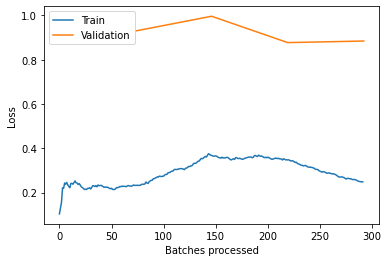

In [68]:
learn.fit_one_cycle(4, slice(1e-03, 1e-02))
learn.save('stage-4')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.216327,0.855776,0.251492,0.748508,00:12
1,0.223534,0.951243,0.284740,0.715260,00:12
2,0.316166,1.119947,0.312020,0.687980,00:12
3,0.357072,1.012695,0.299233,0.700767,00:12
4,0.310266,0.967254,0.285592,0.714408,00:12
5,0.234624,0.903799,0.268542,0.731458,00:12
6,0.194743,0.878907,0.261722,0.738278,00:12
7,0.174847,0.860421,0.256607,0.743393,00:12


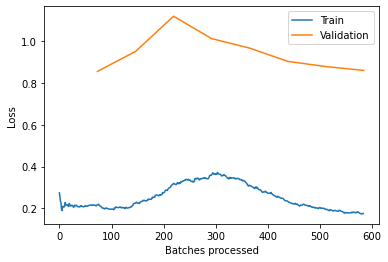

In [69]:
learn.fit_one_cycle(8, slice(1e-03, 1e-02))
learn.save('stage-5')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.162450,0.889216,0.265132,0.734868,00:12
1,0.266526,0.991357,0.279625,0.720375,00:12
2,0.253278,0.900969,0.248082,0.751918,00:12
3,0.209116,0.893479,0.239557,0.760443,00:12


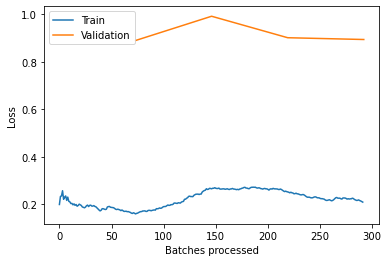

In [70]:
learn.fit_one_cycle(4, slice(1e-03, 1e-02))
learn.save('stage-6')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.169692,0.874707,0.235294,0.764706,00:12
1,0.161802,0.884852,0.238704,0.761296,00:12
2,0.153642,0.873054,0.248934,0.751066,00:12
3,0.193648,0.917617,0.247229,0.752771,00:12
4,0.277887,0.987115,0.274510,0.725490,00:12
5,0.321193,0.978894,0.257459,0.742540,00:12
6,0.316790,0.921377,0.268542,0.731458,00:12
7,0.291921,0.922404,0.253197,0.746803,00:12
8,0.242027,0.909791,0.240409,0.759591,00:12
9,0.200685,0.875159,0.253197,0.746803,00:12


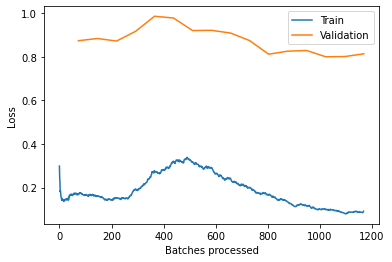

In [71]:
learn.fit_one_cycle(16, slice(1e-03, 1e-02))
learn.save('stage-7')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.108234,0.877195,0.233589,0.766411,00:12
1,0.190593,0.948746,0.238704,0.761296,00:12
2,0.175842,0.844186,0.222506,0.777494,00:12
3,0.131592,0.819491,0.218244,0.781756,00:12


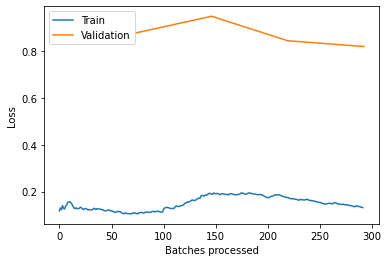

In [77]:
# 3
learn.fit_one_cycle(4, slice(1e-03, 1e-02))
learn.save('stage-8')
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.135841,0.819265,0.221654,0.778346,00:12
1,0.136340,0.879063,0.227621,0.772379,00:12
2,0.197287,0.904097,0.231884,0.768116,00:12
3,0.213481,0.993962,0.247229,0.752771,00:12
4,0.192519,0.920837,0.240409,0.759591,00:12
5,0.152182,0.850055,0.232737,0.767263,00:12
6,0.122859,0.840573,0.228474,0.771526,00:12
7,0.098025,0.849162,0.229327,0.770674,00:12


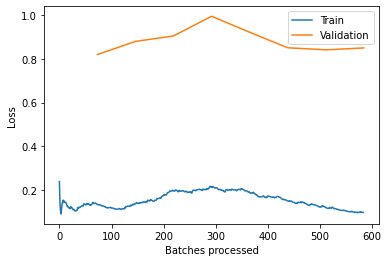

In [79]:
learn.fit_one_cycle(8, slice(1e-03, 1e-02))
learn.save('stage-9')
learn.recorder.plot_losses()

## Results

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

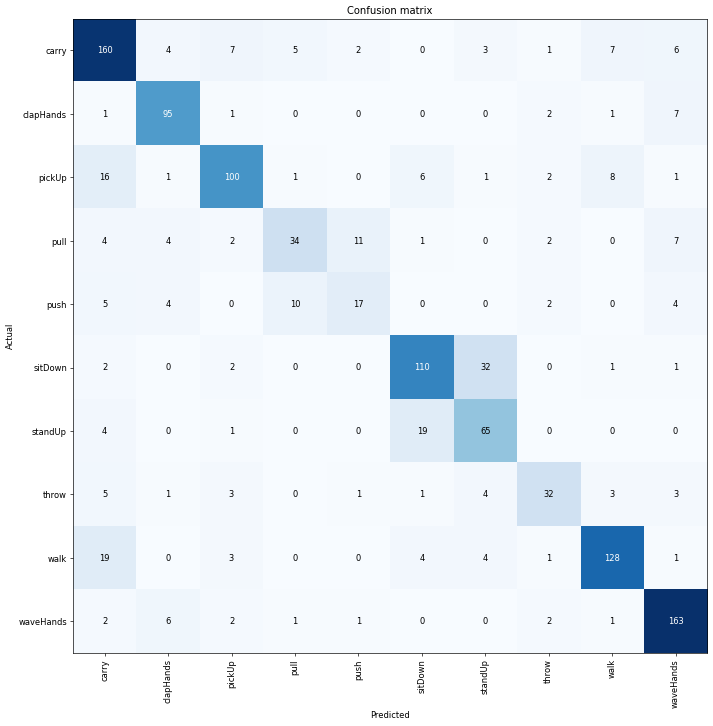

In [81]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [82]:
interp.most_confused(min_val = 2)

[('sitDown', 'standUp', 32),
 ('standUp', 'sitDown', 19),
 ('walk', 'carry', 19),
 ('pickUp', 'carry', 16),
 ('pull', 'push', 11),
 ('push', 'pull', 10),
 ('pickUp', 'walk', 8),
 ('carry', 'pickUp', 7),
 ('carry', 'walk', 7),
 ('clapHands', 'waveHands', 7),
 ('pull', 'waveHands', 7),
 ('carry', 'waveHands', 6),
 ('pickUp', 'sitDown', 6),
 ('waveHands', 'clapHands', 6),
 ('carry', 'pull', 5),
 ('push', 'carry', 5),
 ('throw', 'carry', 5),
 ('carry', 'clapHands', 4),
 ('pull', 'carry', 4),
 ('pull', 'clapHands', 4),
 ('push', 'clapHands', 4),
 ('push', 'waveHands', 4),
 ('standUp', 'carry', 4),
 ('throw', 'standUp', 4),
 ('walk', 'sitDown', 4),
 ('walk', 'standUp', 4),
 ('carry', 'standUp', 3),
 ('throw', 'pickUp', 3),
 ('throw', 'walk', 3),
 ('throw', 'waveHands', 3),
 ('walk', 'pickUp', 3),
 ('carry', 'push', 2),
 ('clapHands', 'throw', 2),
 ('pickUp', 'throw', 2),
 ('pull', 'pickUp', 2),
 ('pull', 'throw', 2),
 ('push', 'throw', 2),
 ('sitDown', 'carry', 2),
 ('sitDown', 'pickUp', 2),